In [89]:
# in the terminal, enter julia, then ] and the command, e.g. add DataFrames
using Random, Distributions, Statistics, DataFrames 
using Random
using Distributions
using Statistics

In [49]:
# We can change these variables or use it as follows
h = 0.1 #storage cost
c = 2.0 #unit profit
p = 0.50 #probability of delivery
K = 40 # fixed order cost
k = 1.0 # variable order cost

average_demand = 20

s = 30 # we will use such s that provide profit sharing
S = 50 

X = 100  # the beginning of the first day of the simulation
profit = 0.0 

0.0

In [50]:
pois = Distributions.Poisson(average_demand)
#the disadvantage of Poisson distribution is low variance, in reality the demand is more chaotic
#you can choose a different distribution to make it real, e.g. normal....

Poisson{Float64}(λ=20.0)

In [51]:
rand(pois, 5)

5-element Vector{Int64}:
 15
 19
 30
 14
 21

In [52]:
# m - number of days
# s - reorder point
# S - target warehouse volume
## we're going to iterate over these functions over s, S, and 'm' - is the number of days
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    pois = Distributions.Poisson(average_demand)
    for day in 1:m
        if Xⱼ < s  # reorder point
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        demand = rand(pois)
        sales = min(Xⱼ, demand)
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        # can add one_objective = 0.75 * profit + 0.01 * lost_orders
         ## or you can multiply by the 'unit cost of stockout' parameter/ k_unit_stockout
         ## k_unit_stockout = k_jedn_stockout
         ## one_objective = 0.75 * profit + 0.01 *lost_orders * k_unit_stockout
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels)
    ## then ....(profit=profit, lost_orders=lost_orders,
    ##    warehouse_levels=warehouse_levels, one_objective=one_objective)
    
end

simulateOneRun (generic function with 1 method)

In [53]:
res = simulateOneRun(20,20,200)
## exemplary execution of the function
## how the warehouse warehouse_levels developed every day - we look at the state of the warehouse and its deliveries
## it may not be '200' here -> possible error

(profit = 769.6, lost_orders = 14.0, warehouse_levels = [100, 83, 62, 45, 25, 4, 200, 175, 158, 138, 114, 86, 70, 52, 35, 25, 200, 178, 161, 143])

In [54]:
res = simulateOneRun(20, 20, 200)
for (day, level) in enumerate(res.warehouse_levels)
    println("Day $day: $level")
end

Day 1: 100
Day 2: 86
Day 3: 62
Day 4: 35
Day 5: 18
Day 6: 6
Day 7: 0
Day 8: 200
Day 9: 177
Day 10: 165
Day 11: 147
Day 12: 120
Day 13: 110
Day 14: 88
Day 15: 73
Day 16: 58
Day 17: 39
Day 18: 26
Day 19: 10
Day 20: 200


In [55]:
@show res.profit
@show res.lost_orders
@show res.warehouse_levels;

res.profit = 576.2000000000003
res.lost_orders = 43.0
res.warehouse_levels = [100, 86, 62, 35, 18, 6, 0, 200, 177, 165, 147, 120, 110, 88, 73, 58, 39, 26, 10, 200]


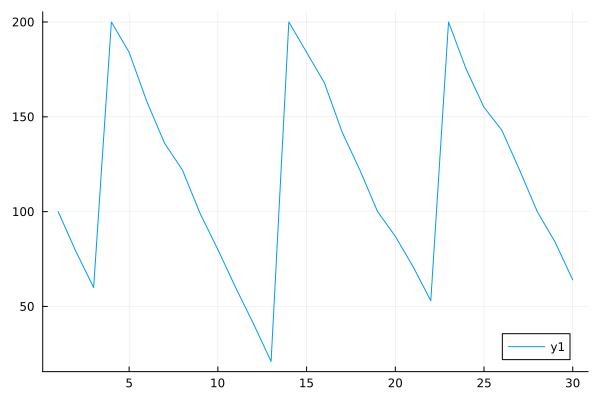

In [56]:
Random.seed!(10)
res = simulateOneRun(30,50,200)

# using PyPlot
# plot(res.warehouse_levels)
# show()
using Plots
plot(res.warehouse_levels)

In [74]:
using DataFrames
res = DataFrame(simulateOneRun(10,5,10) for n in 1:4)

Row,profit,lost_orders,warehouse_levels
,Float64,Float64,Array…
1,255.0,95.0,"[100, 80, 57, 26, 7, 10, 10, 0, 0, 0]"
2,317.9,63.0,"[100, 85, 66, 47, 27, 6, 0, 0, 0, 10]"
3,238.3,73.0,"[100, 81, 60, 43, 25, 10, 0, 0, 0, 10]"
4,252.5,81.0,"[100, 80, 62, 40, 13, 0, 0, 0, 10, 10]"


In [75]:
## average stockouts lost_mean
## 
function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end


run_sims(30,50,100)

(m = 30, s = 50, S = 100, N = 100, profit_mean = 949.6369999999998, profit_std = 108.61257963769921, lost_mean = 34.73, lost_std = 34.93742024439317)

In [76]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(90,s,S,100) 
    for S in 100:100:1000, s in 25:25:250 if S > s )

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,25,100,100,2971.25,187.955,216.66,86.947
2,90,25,200,100,3579.8,143.172,118.92,62.0491
3,90,25,300,100,3488.41,233.743,81.2,61.1899
4,90,25,400,100,3081.23,179.821,60.11,45.8938
5,90,25,500,100,2630.79,167.024,50.72,46.5774
6,90,25,600,100,2546.72,258.47,34.57,38.6717
7,90,25,700,100,1683.64,168.939,33.52,31.9461
8,90,25,800,100,1200.97,281.166,32.05,34.9673
9,90,25,900,100,1367.4,302.588,30.45,37.8336


In [77]:
best_row = argmax(df.profit_mean)

2

In [78]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
2,90,25,200,100,3579.8,143.172,118.92,62.0491


In [79]:
findall(<=(-500), df.profit_mean)'


1×4 adjoint(::Vector{Int64}) with eltype Int64:
 66  74  82  90

In [80]:
df[66,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
66,90,175,1000,100,-507.847,446.965,1.49,9.63002


In [81]:
df[[66, 74,82,90],:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,175,1000,100,-507.847,446.965,1.49,9.63002
2,90,200,1000,100,-772.374,332.434,0.52,5.2
3,90,225,1000,100,-954.18,197.85,1.32,7.08517
4,90,250,1000,100,-1019.13,171.746,0.0,0.0


In [82]:
df[findall(<=(-500), df.profit_mean),:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,90,175,1000,100,-507.847,446.965,1.49,9.63002
2,90,200,1000,100,-772.374,332.434,0.52,5.2
3,90,225,1000,100,-954.18,197.85,1.32,7.08517
4,90,250,1000,100,-1019.13,171.746,0.0,0.0


In [83]:
more500 = findall(>(-500), df.profit_mean)'

1×86 adjoint(::Vector{Int64}) with eltype Int64:
 1  2  3  4  5  6  7  8  9  10  11  12  …  80  81  83  84  85  86  87  88  89

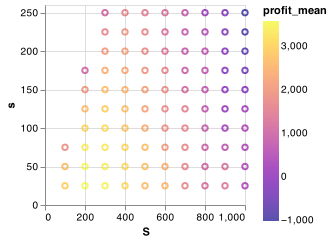

In [84]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

# scatter(df.S[more500],
#         df.s[more500], 
#         c=df.profit_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Profits")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()

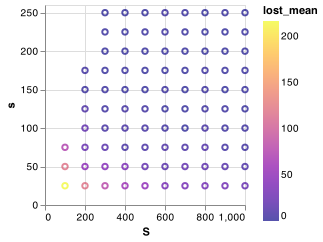

In [85]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:lost_mean, scale={scheme=:plasma}})

        # scatter(df.S[more500],
#         df.s[more500], 
#         c=df.lost_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Lost orders")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()
# savefig(raw"c:\temp\lost_orders.png")

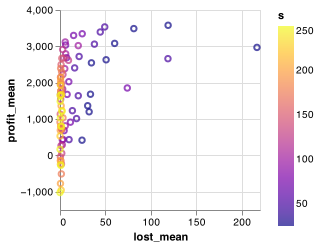

In [86]:
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:s, scale={scheme=:plasma}})

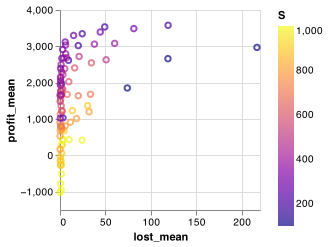

In [87]:
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:S, scale={scheme=:plasma}})

# SIMULATION approach

In [ ]:
# code which simulates the operation of the warehouse system and optimizes the level of the minimum and maximum order:

In [24]:
using Distributions

function simulateOneRun(m, s, S;
    h = 0.1, #koszt przechowywania jednostki towaru
    c = 2.0, #jednostkowy zysk ze sprzedaży
    p = 0.50, #prawdopodobieństwo dostawy
    K = 40, #koszt stałego zamówienia
    k = 1.0, #koszt zmiennej ilości zamówionego towaru
    init_S = 100, #początkowa ilość towaru w magazynie
    average_demand = 20) #średnie dzienne zapotrzebowanie
    
    Xⱼ = init_S #ilość towaru w magazynie
    profit = 0.0 #początkowy zysk
    lost_orders = 0.0 #ilość utraconych zamówień
    warehouse_levels = Int[] #historia stanu magazynu
    pois = Distributions.Poisson(average_demand) #rozkład Poissona dla dziennej liczby sprzedaży
    for day in 1:m #iterujemy po dniach
        if Xⱼ < s #jeśli ilość towaru w magazynie jest mniejsza niż minimalny poziom zamówienia s
            if rand() < p #jeśli dostawa zostanie dostarczona
                profit -= K + (S-Xⱼ)*k #koszt zamówienia
                Xⱼ = S #dodajemy ilość towaru odpowiadającą docelowemu poziomowi magazynu S
            end
        end
        push!(warehouse_levels, Xⱼ) #zapisujemy aktualny stan magazynu
        demand = rand(pois) #losujemy dzienne zapotrzebowanie na towar
        sales = min(Xⱼ, demand) #sprzedajemy towar, który jest dostępny w magazynie
        Xⱼ -= sales #zmniejszamy stan magazynu o sprzedaną ilość
        @assert Xⱼ >= 0 #sprawdzamy, czy ilość towaru w magazynie nie jest ujemna
        lost_order = demand - sales #liczymy ilość utraconych zamówień
        @assert lost_order >= 0 #sprawdzamy, czy ilość utraconych zamówień nie jest ujemna
        profit += sales*c - (Xⱼ-sales)*h #dodajemy zysk ze sprzedaży i koszty przechowywania
        lost_orders += lost_order #dodajemy ilość utraconych zamówień
    end
    
    (profit=profit, lost_orders=lost_orders, warehouse_levels=warehouse_levels)
end


simulateOneRun (generic function with 1 method)

In [25]:
#The simulateManyRuns function takes in the same arguments as simulateOneRun, but also takes additional arguments:

#n: number of runs to simulate for each combination of s and S
#s_min and s_max: range of values for s to simulate over
#S_min and S_max: range of values for S to simulate over
#It then iterates over all combinations of s and S within the given ranges, 
#and simulates n runs for each combination using the simulateOneRun function. 
#The results for each run are stored in separate vectors, which are returned as a tuple.
function simulateManyRuns(n, m, s_range, S_range; kwargs...)
    profits = Float64[]
    lost_orders = Float64[]
    s_values = Int[]
    S_values = Int[]
    warehouse_levels = Vector{Int}[]
    
    for s in s_range
        for S in S_range
            for run in 1:n
                res = simulateOneRun(m, s, S; kwargs...)
                push!(profits, res.profit)
                push!(lost_orders, res.lost_orders)
                push!(warehouse_levels, res.warehouse_levels)
                push!(s_values, s)
                push!(S_values, S)
            end
        end
    end
    
    return (profits=profits,
            lost_orders=lost_orders,
            s_values=s_values,
            S_values=S_values,
            warehouse_levels=warehouse_levels)
end


simulateManyRuns (generic function with 1 method)

In [30]:
# parametry symulacji
m = 30 # liczba dni
n = 10 # liczba powtórzeń dla każdej kombinacji s i S
s_range = 20:5:50 # zakres poziomu minimalnego zamówienia
S_range = 100:50:300 # zakres poziomu maksymalnego zamówienia
kwargs = Dict(
    :h => 0.1,
    :c => 4.0,
    :p => 0.50,
    :K => 100,
    :k => 1.0,
    :init_S => 100,
    :average_demand => 20
)

# wykonanie symulacji
Random.seed!(10)
avg_payoffs = simulateManyRuns(n, m, s_range, S_range; kwargs...)

(profits = [1008.8, 1250.8999999999999, 1136.7, 1115.5, 1204.7, 1194.9000000000003, 1150.6, 1023.9000000000001, 1049.2, 1054.3999999999999  …  1235.9, 1094.0, 975.0000000000002, 1230.3000000000002, 1182.0000000000002, 1139.2, 1182.9, 1242.5000000000002, 1252.6000000000001, 1374.8999999999999], lost_orders = [107.0, 41.0, 23.0, 122.0, 42.0, 33.0, 86.0, 75.0, 69.0, 123.0  …  0.0, 0.0, 0.0, 0.0, 11.0, 0.0, 0.0, 29.0, 0.0, 0.0], s_values = [20, 20, 20, 20, 20, 20, 20, 20, 20, 20  …  50, 50, 50, 50, 50, 50, 50, 50, 50, 50], S_values = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100  …  300, 300, 300, 300, 300, 300, 300, 300, 300, 300], warehouse_levels = [[100, 79, 60, 38, 20, 4, 0, 0, 100, 81  …  32, 14, 100, 75, 55, 43, 22, 100, 74, 54], [100, 81, 62, 39, 12, 100, 74, 63, 48, 27  …  56, 32, 16, 0, 100, 77, 52, 27, 100, 76], [100, 82, 52, 34, 12, 0, 100, 82, 60, 42  …  23, 100, 86, 67, 42, 21, 100, 74, 58, 38], [100, 78, 51, 36, 17, 100, 72, 50, 26, 100  …  48, 27, 6, 0, 0, 100, 85, 65, 

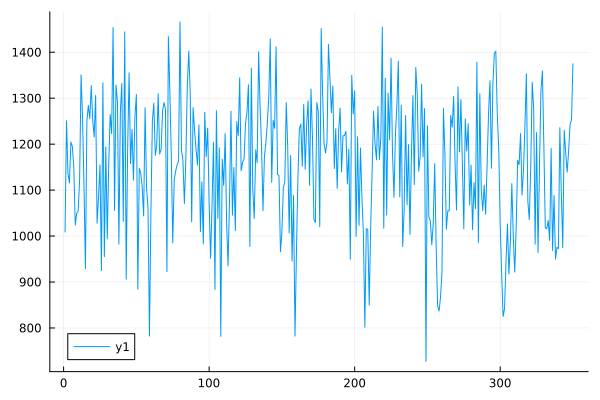

In [35]:
plot(avg_payoffs.profits)

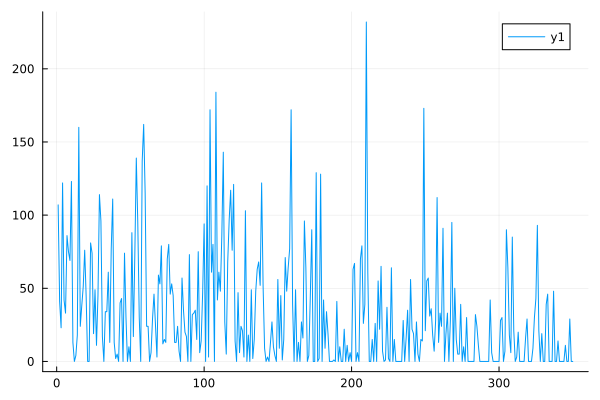

In [36]:
plot(avg_payoffs.lost_orders)

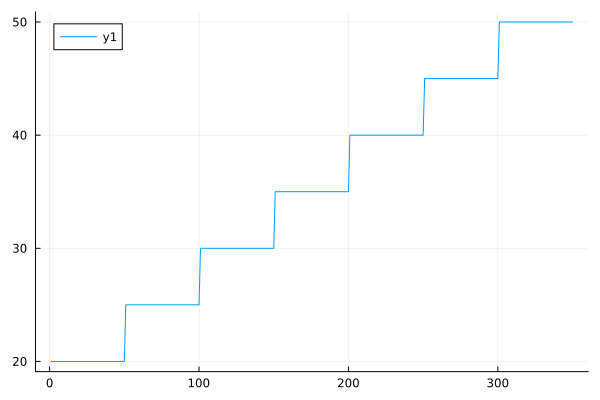

In [37]:
plot(avg_payoffs.s_values)

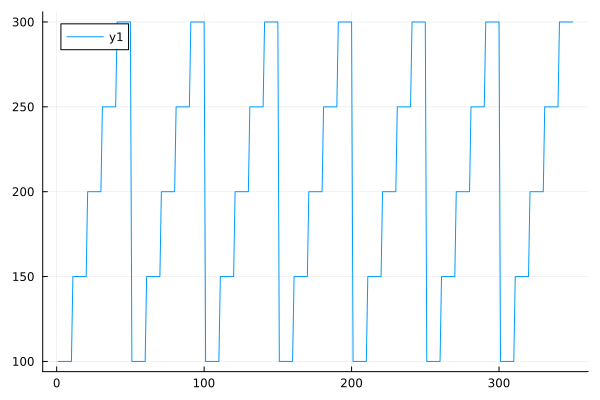

In [38]:
plot(avg_payoffs.S_values)

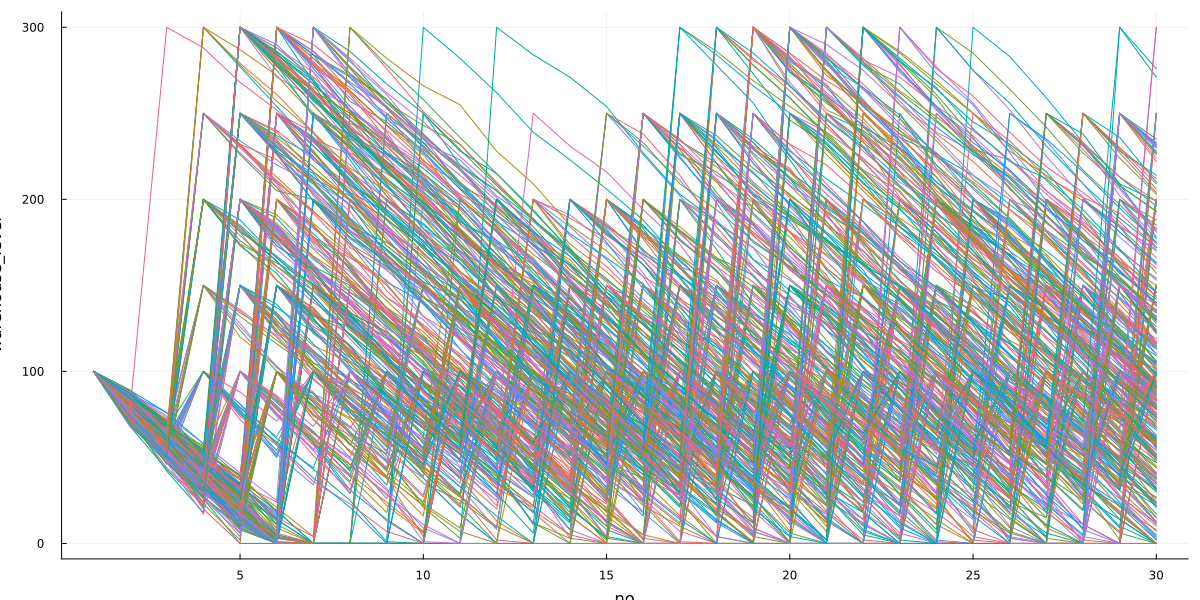

In [91]:
using Plots
p=plot(size=(1200,600)) # set size to 1200x600 pixels
i=0
for warehouse_level in avg_payoffs.warehouse_levels
    plot!(warehouse_level, label="lvl $i", legend=false)
    i+=1
end

xlabel!("no")
ylabel!("warehouse_level")

# OPTIMIZATION approach

### profit maximization 

In [88]:
#assumptions
h = 0.1 #koszt przechowywania jednostki towaru    
c = 2.0 #jednostkowy zysk ze sprzedaży
p = 0.50 #prawdopodobieństwo dostawy
K = 40 #koszt stałego zamówienia
k = 1.0 #koszt zmiennej ilości zamówionego towaru
init_S = 100 #początkowa ilość towaru w magazynie
average_demand = 20 #średnie dzienne zapotrzebowanie

20

In [ ]:
using Optim

# Define the objective function to be maximized
function objective_function(x)
    s = x[1]
    S = x[2]
    results = simulateManyRuns(100, 365, s:s+10, S:S+50, init_S = S, s_min = s, s_max = s+10, S_min = S, S_max = S+50)
    return -mean(results.profits)
end

# Set up the optimization problem
initial_guess = [20, 100] # initial guess for s and S
lower_bounds = [0, 0] # lower bounds for s and S
upper_bounds = [100, 500] # upper bounds for s and S
opt = optimize(objective_function, lower_bounds, upper_bounds, initial_guess)

# Print the optimal values of s and S, as well as the maximum profit
println("Optimal s: ", opt.minimizer[1])
println("Optimal S: ", opt.minimizer[2])
println("Maximum profit: ", -opt.minimum)


### cost minimization